## Some Theory

- [SAM2](https://github.com/facebookresearch/sam2) (Meta's Segment Anything Model 2, 39M-224M params): Meta’s first unified model that can segment objects in both images and videos in real time. Fine-tuning SAM2 allows you to adapt SAM2 to your specific needs, improving its accuracy and efficiency for your particular use case  

- [LoRA](https://arxiv.org/abs/2106.09685): Research showed that weight changes during fine-tuning lie in a low-dimensional subspace. This means you don't need to update all dimensions - most of the "movement" happens in a small subset. 
    - When finetuning, we do `ΔW = W_finetuned - W_pretrained` where ΔW has very low "intrinsic rank" (most singular values are near zero, only ~8-64 dimensions actually matter). LoRA insight: `ΔW ≈ B × A` - we approximate `ΔW` with `B` and `A` where `A` is the "down-projection" matrix `(r × d_in), with r small (8-64)`, and `B` is the "up-projection" matrix `(d_out × r)`. So the total params to fine tune would be `r × d_in + d_out × r = r × (d_in + d_out)`
    - Original delta weight: `ΔW` e.g. `4096 × 4096 = 16M` params. With `r=16`: `A` is (`4096 × 16`) + `B` is (`16 × 4096`) = `131K` params (99.2% reduction)

- Fed LoRA SAM2: Finetune SAM2 using LoRA technique in a federated setting where data never leaves hospitals, and since only LoRA adapters are transfered, communication are very light

## Data Exploration and Preparation

We use the [Chest CT Segmentation](https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation/) dataset from Kaggle

In [11]:
import shutil
from pathlib import Path
import kagglehub

# Download latest version
path = kagglehub.dataset_download("polomarco/chest-ct-segmentation")
print("Path to dataset files:", path)

# Check if ../dataset/chest-ct-segmentation exists, if not copy the downloaded dataset there
dataset_dir = Path("../dataset/chest-ct-segmentation")
if not dataset_dir.exists():
    print(f"Copying dataset to {dataset_dir}...")
    shutil.copytree(path, dataset_dir)
    print("Dataset copied successfully!")
else:
    print(f"Dataset already exists at {dataset_dir}")

Path to dataset files: /Users/khoaguin/.cache/kagglehub/datasets/polomarco/chest-ct-segmentation/versions/3
Dataset already exists at ../dataset/chest-ct-segmentation


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import train_test_split

# Path to the chest-ct-segmentation dataset folder
data_dir = Path("../dataset/chest-ct-segmentation")
images_dir = data_dir / "images/images"
masks_dir = data_dir / "masks/masks"

# Load the train.csv file
train_df = pd.read_csv(data_dir / "train.csv")

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df.head()


,ImageId,MaskId
14475,ID00381637202299644114027_20.jpg,ID00381637202299644114027_mask_20.jpg
7988,ID00186637202242472088675_160.jpg,ID00186637202242472088675_mask_160.jpg
6954,ID00161637202235731948764_14.jpg,ID00161637202235731948764_mask_14.jpg
2519,ID00060637202187965290703_173.jpg,ID00060637202187965290703_mask_173.jpg
10826,ID00249637202266730854017_121.jpg,ID00249637202266730854017_mask_121.jpg


Prepare the training data list

In [13]:
train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": (images_dir / image_name),
       "annotation": (masks_dir / mask_name)
   })
print(f"Total training samples: {len(train_data)}")

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": (images_dir / image_name),
       "annotation": (masks_dir / mask_name)
   })
print(f"Total testing samples: {len(test_data)}")

Total training samples: 13366
Total testing samples: 3342


Reading and resizing images

In [14]:
import cv2

def read_batch(data, max_size=1024, visualize=False):
    """
    Read a random image-mask pair from data and prepare it for SAM2.
    
    Returns:
        img: RGB image array
        binary_mask: Binary mask with shape (1, H, W)
        points: Sample points with shape (N, 1, 2)
        num_masks: Number of unique mask regions
    """
    # Select a random entry
    entry = data[np.random.randint(len(data))]
    
    # Read image (BGR -> RGB) and mask
    img = cv2.imread(str(entry["image"]))[..., ::-1]
    mask = cv2.imread(str(entry["annotation"]), cv2.IMREAD_GRAYSCALE)
    
    if img is None or mask is None:
        print(f"Error: Could not read {entry['image']} or {entry['annotation']}")
        return None, None, None, 0
    
    # Resize to fit within max_size
    scale = min(max_size / img.shape[1], max_size / img.shape[0])
    new_size = (int(img.shape[1] * scale), int(img.shape[0] * scale))
    img = cv2.resize(img, new_size)
    mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)
    
    # Create binary mask from all non-background regions
    unique_labels = np.unique(mask)[1:]  # Skip background (0)
    binary_mask = (mask > 0).astype(np.uint8)
    
    # Early return if no foreground
    if len(unique_labels) == 0:
        return None, None, None, 0
    
    # Sample points from eroded mask (to avoid boundaries)
    eroded = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)
    coords = np.argwhere(eroded > 0)
    
    # Early return if erosion removed all foreground
    if len(coords) == 0:
        return None, None, None, 0
    
    # Sample one point per unique label
    points = []
    for _ in unique_labels:
        yx = coords[np.random.randint(len(coords))]
        points.append([yx[1], yx[0]])  # Convert to (x, y)
    points = np.array(points)
    
    if visualize:
        _visualize_batch(img, binary_mask, points)
    
    # Reshape for SAM2: mask (1, H, W), points (N, 1, 2)
    binary_mask = binary_mask[np.newaxis, :, :]
    points = points[:, np.newaxis, :]
    
    return img, binary_mask, points, len(unique_labels)


def _visualize_batch(img, binary_mask, points):
    """Visualize image, mask, and sample points."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(binary_mask, cmap='gray')
    axes[1].set_title('Binary Mask')
    axes[1].axis('off')
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title('Mask with Sample Points')
    colors = list(mcolors.TABLEAU_COLORS.values())
    for i, pt in enumerate(points):
        axes[2].scatter(pt[0], pt[1], c=colors[i % len(colors)], s=100)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

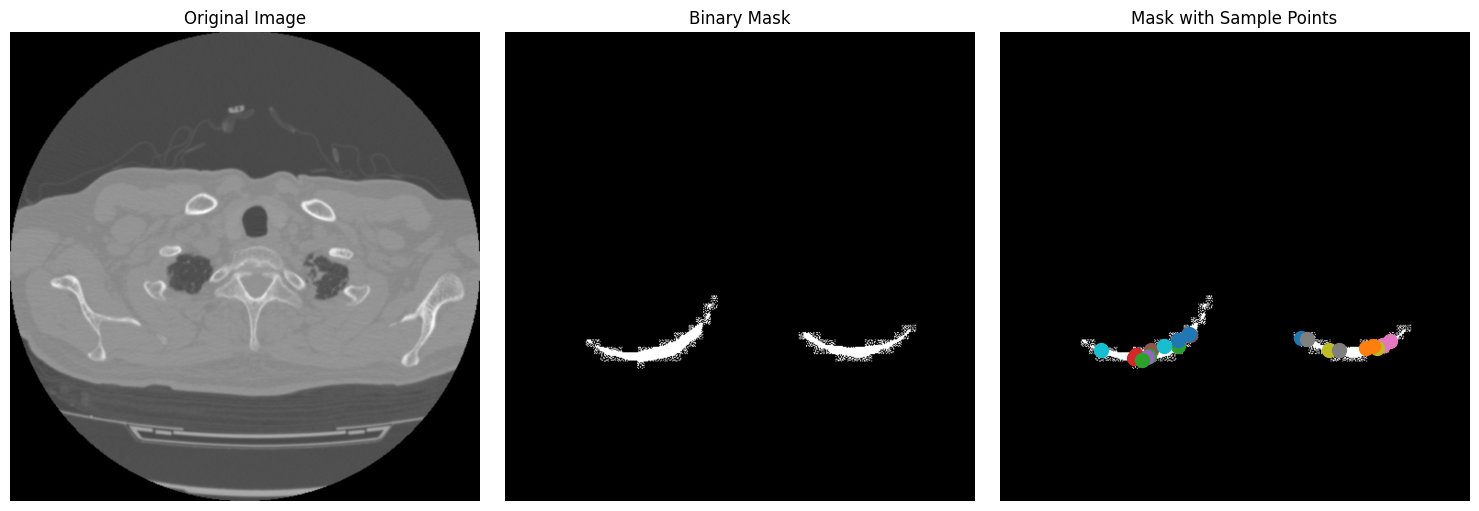

Image shape: (1024, 1024, 3), Mask shape: (1, 1024, 1024), Points shape: (23, 1, 2), Num masks: 23


In [15]:
# Visualize a sample batch
img, mask, points, num_masks = read_batch(train_data, visualize=True)
print(f"Image shape: {img.shape}, Mask shape: {mask.shape}, Points shape: {points.shape}, Num masks: {num_masks}")

## Fine-tuning the SAM2 model

First, download pretrained sam2 weights

In [16]:
from pathlib import Path

pretrained_weight_path = Path("../models/pretrained/sam2_hiera_tiny.pt")

if not pretrained_weight_path.exists():
    !wget -O {pretrained_weight_path} "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"

print("Pretrained weights downloaded to:", pretrained_weight_path)

Pretrained weights downloaded to: ../models/pretrained/sam2_hiera_tiny.pt


In [17]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Auto-detect device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

sam2_checkpoint = "../models/pretrained/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

Using device: mps


In [18]:
sam2_model

SAM2Base(
  (image_encoder): ImageEncoder(
    (trunk): Hiera(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): MLP(
            (layers): ModuleList(
              (0): Linear(in_features=96, out_features=384, bias=True)
              (1): Linear(in_features=384, out_features=96, bias=True)
            )
            (act): GELU(approximate='none')
          )
        )
        (1): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      

Hyperparameters

In [19]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(
    params=predictor.model.parameters(),
    lr=0.0001,
    weight_decay=1e-4
) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.amp.GradScaler(enabled=(device.type == "cuda"))

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"


In [20]:
# Training config
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2)
accumulation_steps = 4
mean_iou = 0

# Determine autocast device type
autocast_dtype = torch.float16 if device.type == "cuda" else torch.bfloat16
use_amp = device.type in ("cuda", "cpu")  # MPS doesn't support autocast well

for step in range(1, NO_OF_STEPS + 1):
    with torch.amp.autocast(device_type=device.type, dtype=autocast_dtype, enabled=use_amp):
        # 1. Load random image + mask + sample points
        image, mask, input_point, num_masks = read_batch(train_data, visualize=False)
        if image is None or mask is None or num_masks == 0:
            continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue
        if input_point.size == 0 or input_label.size == 0:
            continue
        
        # 2. Prepare prompts for SAM2
        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )
        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0:
            continue
        
        # 3. Get prompt embeddings
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None,
        )

        # 4. Predict & Decode masks
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
        
        # 5. Compute loss = segmentation loss + score loss
        gt_mask = torch.tensor(mask.astype(np.float32)).to(device)
        prd_mask = torch.sigmoid(prd_masks[:, 0])
        seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log(1 - prd_mask + 1e-6)).mean()

        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05

        # 6. Backprop with gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

    # Clip gradients
    torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

    # 7. Update weights every accumulation_steps, then step scheduler
    if step % accumulation_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        predictor.model.zero_grad()
        scheduler.step()  # Must be called AFTER optimizer.step()

    # 8. Save checkpoint every 500 steps
    if step % 500 == 0:
        checkpoint_path = f"{FINE_TUNED_MODEL_NAME}_{step}.torch"
        torch.save(predictor.model.state_dict(), checkpoint_path)

    # 9. Log IoU every 100 steps
    mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
    if step % 100 == 0:
        print(f"Step {step}:\tAccuracy (IoU) = {mean_iou:.4f}")

Step 100:	Accuracy (IoU) = 0.2289


KeyboardInterrupt: 